In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math
import numpy as np

class DataSet():
    def __init__(self, num_words=None, seed=113, maxlen=100, train_portion=0.5, long_first=False):
        """
        :param num_words: Size of vocabulary, all words out-of-vocabulary will be marked as [unk]
        :param seed: Seed for randomly shuffling dataset
        :param maxlen: Maximum length of review, reviews longer than maxlen will be truncated, reviews shorter than
        maxlen will be padded to maxlen
        :param train_portion: Portion of dataset to allocate to training data, test data will be 1-train_portion
        :param long_first: Sort reviews by length
        """
        # retrieve IMDb data, x is a sequence containing movie review,
        # y is a label indicating if it is positive or negative sentiment
        (self.x_train, self.y_train), (self.x_test, self.y_test) = imdb.load_data(num_words=num_words, seed=seed)

        if long_first:
            self.y_train = [y for _, y in sorted(zip(self.x_train, self.y_train), key=lambda s: len(s[0]), reverse=True)]
            self.x_train = sorted(self.x_train, key=len, reverse=True)

            self.y_test = [y for _, y in sorted(zip(self.x_test, self.y_test), key=lambda s: len(s[0]), reverse=True)]
            self.x_test = sorted(self.x_test, key=len, reverse=True)

        self.total_length = [len(x) for x in self.x_train]
        temp = [len(x) for x in self.x_test]
        self.total_length.extend(temp)

        # padding sequences to all be of the same length
        self.x_train = pad_sequences(self.x_train, maxlen=maxlen, padding='post', truncating='post')
        self.x_test = pad_sequences(self.x_test, maxlen=maxlen, padding='post', truncating='post')

        self.split_data(train_portion)

        self.word_index = imdb.get_word_index()
        self.word_to_index = {word:id + 3 for word, id in self.word_index.items()}
        self.word_to_index["[pad]"] = 0
        self.word_to_index["[start]"] = 1
        self.word_to_index["[unk]"] = 2
        self.word_to_index["[unused]"] = 3
        self.index_to_word = {i:word for (word, i) in self.word_to_index.items()}
        self.form_vocab()

    def form_vocab(self):
        i2w_vocab = {}
        w2i_vocab = {}

        for sentence in self.x_train:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id

        for sentence in self.x_test:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id
        self.i2w_vocab = i2w_vocab
        self.w2i_vocab = w2i_vocab

    def get_data(self):
        return (self.x_train, self.y_train), (self.x_test, self.y_test), (self.train_length, self.test_length)

    def get_vocab_length(self):
        return len(self.i2w_vocab)

    # splits data into ratio train:test -> (train_portion:1-train_portion)
    def split_data(self, train_portion):
        x = np.concatenate((self.x_train, self.x_test), axis=0)
        y = np.concatenate((self.y_train, self.y_test), axis=0)
        self.train_length, self.test_length = self.total_length[:math.floor(train_portion * len(x))], \
                                              self.total_length[math.floor(train_portion * len(x)):]
        self.x_train, self.x_test = x[:math.floor(train_portion * len(x))], \
                                    x[math.floor(train_portion * len(x)):]
        self.y_train, self.y_test = y[:math.floor(train_portion * len(y))], \
                                    y[math.floor(train_portion * len(y)):]
        return None


2023-07-24 07:36:05.859621: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
maxlen = 500
batch_size = 128
VOCAB_size = 4000
INPUT_SIZE=500
dataset = DataSet(VOCAB_size, maxlen=INPUT_SIZE, train_portion=0.7)
(x_train, y_train), (x_test, y_test),(_,_) = dataset.get_data()

In [3]:
print(x_test[94])

[   1  614 1028   17  826 1881   47   38 2105  617   11   27 1635    7
    4    2 2355   12    9  179  614    8   97   52  108   60   87  663
  746    4 3818  939  512    4  512   47    2    2    2    2  145    8
    4    2    2  572    4    2    2  725   63    2    5   85    2   28
 1309 1635    7    4    2  972  190   12    9  878    8  104    7  101
   85 2554    5    2  108   63   26  101   52   13   62 1041   19    4
 2215   37  301   15    4  118    7    6   78  762   16 2709    2    5
   60   15 3301  117    2   85   74   15    7  112    6 1533 1501   22
   17 3630    8    6    2   78   31  767  190  566 2715    4   60   53
    2    2    7  112  331    6   78   22   17 3630    8   35 3577   31
   10   10   17   19  111    7    4  114  791   11  767   26    2   39
    4 1635    7    4    2   35  445    2    2    8 3235 1140    7   35
    2   19 2467 1722   11  661    8 2715   35    2    7  182    2   21
    9    2   34   35    2  604    7 1737    4   22  270   11    4  559
    6 

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow.keras.regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.datasets import imdb
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import numpy as np
import matplotlib as matplot
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import math
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import pickle
from tensorflow.keras.layers import GaussianNoise
# set up hyperparameters
# max_features = 50000
maxlen = 500
batch_size = 128
VOCAB_size = 4000
INPUT_SIZE=500

dataset = DataSet(VOCAB_size, maxlen=INPUT_SIZE, train_portion=0.7)
with open('ineight/dataset_4000_70.pkl', 'wb') as f:
    pickle.dump(dataset, f)
(x_train, y_train), (x_test, y_test),(_,_) = dataset.get_data()
#vocab_size = dataset.get_vocab_length()


print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# set up keras LSTM nn
model_s = keras.Sequential()
model_s.add(Embedding(VOCAB_size, output_dim=32, input_length=500,weights=weights,trainable=False))
model_s.add(CuDNNLSTM(60,kernel_initializer=tf.keras.initializers.Constant(0),recurrent_initializer=tf.keras.initializers.Constant(0)
))
model_s.add(tf.keras.layers.Dense(1, activation='sigmoid',weights=weights2,trainable=False))
opt = tf.keras.optimizers.Adam()

model_s.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#def schedule(epoch):
    #if epoch < 20:
        #return 0.0005
    #if epoch < 200:
        #return 0.0001
    #if epoch < 300:
        #return 0.00005
    #if epoch < 900:
        #return 0.00001
    #else:
        #return 0.000005

#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)




#model.predict(x_test)



checkpoint_filepath='ineight/weights.{epoch:02d}.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor= 'val_loss',
    verbose= 0,
    save_best_only= False,
    save_weights_only = False,
    mode= 'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)

history = model_s.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=1000,
                    validation_data=(x_test, y_test),
                     callbacks=[model_checkpoint_callback])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))



plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



x_train shape: (35000, 500)
x_test shape: (15000, 500)
Epoch 1/1000


2023-07-24 07:36:34.331420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-24 07:36:34.630876: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f0fb5b06910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-24 07:36:34.630915: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2023-07-24 07:36:34.640181: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-24 07:36:34.850642: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 [==============================] - 13s 40ms/step - loss: 0.6738 - accuracy: 0.5325 - val_loss: 0.7050 - val_accuracy: 0.5103
Epoch 2/1000
274/274 [==============================] - 10s 35ms/step - loss: 0.6658 - accuracy: 0.5314 - val_loss: 0.7063 - val_accuracy: 0.5075
Epoch 3/1000
274/274 [==============================] - 9s 34ms/step - loss: 0.6522 - accuracy: 0.5409 - val_loss: 0.7291 - val_accuracy: 0.5293
Epoch 4/1000
274/274 [==============================] - 9s 34ms/step - loss: 0.6832 - accuracy: 0.5556 - val_loss: 0.6182 - val_accuracy: 0.6343
Epoch 5/1000
274/274 [==============================] - 10s 35ms/step - loss: 1.0306 - accuracy: 0.5953 - val_loss: 0.7225 - val_accuracy: 0.4977
Epoch 6/1000
274/274 [==============================] - 10s 36ms/step - loss: 0.6795 - accuracy: 0.5240 - val_loss: 0.7012 - val_accuracy: 0.5125
Epoch 7/1000
274/274 [==============================] - 9s 35ms/step - loss: 0.5431 - accuracy: 0.7403 - val_loss: 0.5629 - val_accuracy: 0

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
total=[]
for i in range(len(acc)):
    total.append([acc[i],val_acc[i],loss[i],val_loss[i]])
np.savetxt('ineight/summary.txt',total)


plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.savefig('ineight/acc.png')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.ylim(0,0.9)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('ineight/loss.png')
plt.show()



In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow.keras.regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib as matplot
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import math
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import pickle
from tensorflow.keras.layers import GaussianNoise

In [2]:
from tensorflow import keras
from tensorflow.keras.models import load_model
def path_weight(n):
    path='LSTM/'+'weights.'+str(n)+'.hdf5'
    model=load_model(path)
    weights = model.layers[1].get_weights()
    p=weights[1].reshape(14400).tolist()+weights[0].reshape(7680).tolist()+weights[2].tolist()
    scipy.stats.moment(p, moment=2)
    return p


In [333]:
from tensorflow import keras
from tensorflow.keras.models import load_model
def path_weight22(n):
    path='LSTM/'+'weights.'+str(n)+'.hdf5'
    model=load_model(path)
    weights = model.layers[1].get_weights()
    p=weights[1].reshape(14400).tolist()+weights[2].tolist()
    scipy.stats.moment(p, moment=2)
    return p

In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow.keras.regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib as matplot
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import math
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import pickle
from tensorflow.keras.layers import GaussianNoise

In [4]:
path='LSTM/'+'weights.112'+'.hdf5'
model=load_model(path)
weights = model.layers[0].get_weights()
weights2= model.layers[2].get_weights()

2023-07-24 07:36:12.251131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29615 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0
2023-07-24 07:36:13.168459: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-24 07:36:13.170602: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/sp

In [4]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-07-21 14:47:32.107713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /device:GPU:0 with 31119 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


True

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


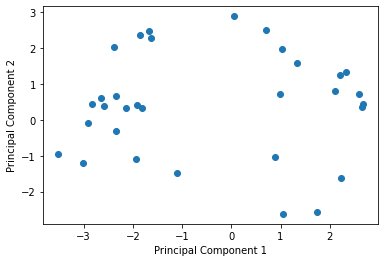

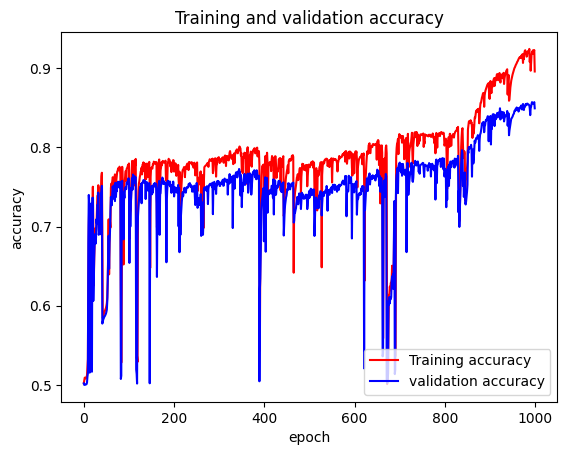

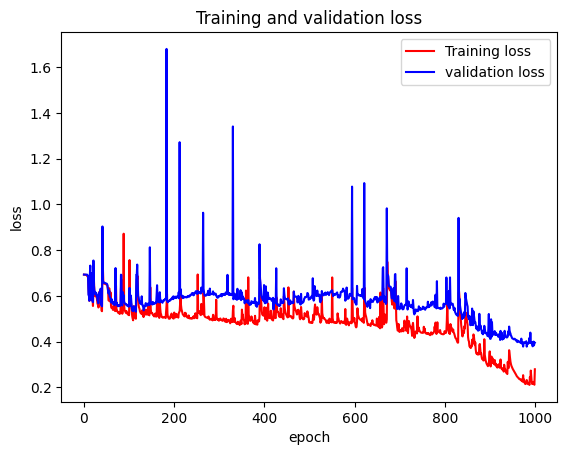

In [4]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
#plt.savefig('paper2weights/acc.png')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig('paper/loss.png')
plt.show()


import numpy as np
from matplotlib import pyplot as plt
#yd = 5*np.cos(zd)
#ax1.scatter3D(xd,yd,zd, cmap='Blues')  #绘制散点图
#ax1.plot3D(x,y,z,'gray')    #绘制空间曲线
#plt.show()
ax=[]
ay=[]
az=[]
for e in y:
    ax.append(e[0])
    ay.append(e[1])
    az.append(e[2])
    e=np.array(e)
    print(sum(abs(e[1:])))
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.scatter3D(ax,ay,az, cmap='Blues')  #绘制散点图
#ax1.plot3D(ax,ax,az,'gray')    #绘制空间曲线
plt.show()

In [ ]:
path='inzero/'+'weights0.'+str(1)+'.hdf5'
model=load_model(path)
weights = model.layers[1].get_weights()
weights[2]

In [25]:
np.shape(np.float64(np.zeros((480,))))

(480,)

In [18]:
np.savetxt('paper/weights_var.txt',x)    
print("保存文件成功")

保存文件成功


In [189]:
weights = np.array(model.layers[1].get_weights()[0]).flatten()
weights1 = np.array(model.layers[1].get_weights()[1]).flatten()
weightsb = np.array(model.layers[1].get_weights()[2]).flatten()

In [213]:
np.dot(np.ones((14400,)),weights1.flatten())

-101.16703673794109

In [157]:
from sklearn.decomposition import PCA

In [169]:
pca=PCA(2)
p=pca.fit_transform(weights)

In [176]:
t1=list(scipy.stats.moment(p, moment=2,axis=0))

In [170]:
t2=list(scipy.stats.moment(p, moment=2,axis=0))

In [171]:
t2[1]-t1[1]

-0.00082588196

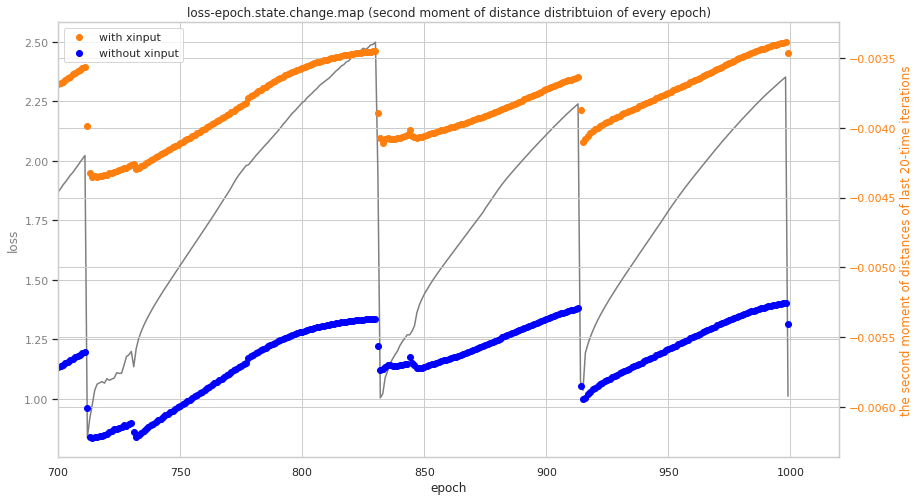

In [379]:
l2=[1.5603,
 1.5755,
 1.5907,
 1.6059,
 1.6211,
 1.6363,
 1.6516,
 1.6667,
 1.6822,
 1.6976,
 1.7132,
 1.7287,
 1.7443,
 1.7598,
 1.7757,
 1.7914,
 1.8071,
 1.8227,
 1.8388,
 1.8551,
 1.8718,
 1.8891,
 1.9074,
 1.9247,
 1.9398,
 1.9533,
 1.967,
 1.9798,
 1.9832,
 1.996,
 2.0085,
 2.0213,
 2.033,
 2.0442,
 2.0564,
 2.0674,
 2.0778,
 2.0901,
 2.1014,
 2.1133,
 2.1246,
 2.1368,
 2.1512,
 2.1626,
 2.1749,
 2.188,
 2.2005,
 2.2098,
 2.2212,
 2.2327,
 2.2442,
 2.2516,
 2.2648,
 2.2741,
 2.2834,
 2.2946,
 2.3032,
 2.3153,
 2.3239,
 2.3314,
 2.3397,
 2.3471,
 2.3575,
 2.3679,
 2.3787,
 2.3864,
 2.3985,
 2.4036,
 2.415,
 2.4195,
 2.4297,
 2.4403,
 2.448,
 2.4552,
 2.4631,
 2.4728,
 2.4678,
 2.4757,
 2.4866,
 2.4889,
 2.4983,
 1.9494,
 1.0038,
 1.0215,
 1.0896,
 1.1173,
 1.1494,
 1.1674,
 1.1852,
 1.2001,
 1.2233,
 1.2404,
 1.2546,
 1.2688,
 1.2689,
 1.2844,
 1.307,
 1.3626,
 1.3943,
 1.4189,
 1.4393,
 1.4572,
 1.4741,
 1.4905,
 1.506,
 1.5208,
 1.5355,
 1.55,
 1.5639,
 1.5777,
 1.5918,
 1.6056,
 1.6192,
 1.6327,
 1.6463,
 1.6602,
 1.6738,
 1.6876,
 1.7013,
 1.7149,
 1.7287,
 1.7424,
 1.756,
 1.7694,
 1.7827,
 1.7999,
 1.8143,
 1.8294,
 1.8447,
 1.86,
 1.8749,
 1.8892,
 1.9029,
 1.9161,
 1.9287,
 1.9407,
 1.953,
 1.9647,
 1.9763,
 1.988,
 1.9994,
 2.011,
 2.0223,
 2.0338,
 2.0446,
 2.0557,
 2.0666,
 2.0776,
 2.0886,
 2.0988,
 2.1098,
 2.1206,
 2.1308,
 2.1418,
 2.1521,
 2.1625,
 2.1733,
 2.1829,
 2.1927,
 2.2023,
 2.2116,
 2.2208,
 2.2297,
 2.2391,
 1.0741,
 1.0359,
 1.1935,
 1.2286,
 1.2593,
 1.285,
 1.3084,
 1.3295,
 1.3494,
 1.3682,
 1.3863,
 1.4037,
 1.4207,
 1.4372,
 1.4536,
 1.4696,
 1.4854,
 1.501,
 1.5165,
 1.5318,
 1.5471,
 1.5625,
 1.5776,
 1.5928,
 1.6078,
 1.6228,
 1.6377,
 1.6527,
 1.6677,
 1.6826,
 1.6977,
 1.7127,
 1.7277,
 1.7429,
 1.7582,
 1.7737,
 1.7894,
 1.8045,
 1.8193,
 1.8339,
 1.8481,
 1.8621,
 1.8759,
 1.8896,
 1.9029,
 1.916,
 1.9291,
 1.942,
 1.9551,
 1.9677,
 1.9804,
 1.9929,
 2.0057,
 2.0183,
 2.0309,
 2.0434,
 2.0559,
 2.0682,
 2.0803,
 2.0922,
 2.1042,
 2.1159,
 2.1273,
 2.1387,
 2.1503,
 2.1615,
 2.1727,
 2.1836,
 2.1945,
 2.2055,
 2.2163,
 2.2272,
 2.2376,
 2.2481,
 2.2584,
 2.2686,
 2.2783,
 2.2877,
 2.2973,
 2.3066,
 2.3158,
 2.3253,
 2.3342,
 2.3432,
 2.3518,
 1.011,
 1.1118,
 1.1686,
 1.1987,
 1.2236,
 1.2455,
 1.2652,
 1.2837,
 1.3013,
 1.3181,
 1.3343,
 1.3501,
 1.3656,
 1.3806,
 1.3956,
 1.4104,
 1.4249,
 1.4395,
 1.4538]
l2=[1.8685,
 1.8821,
 1.8982,
 1.9109,
 1.9246,
 1.9395,
 1.9506,
 1.9653,
 1.9786,
 1.9938,
 2.0077,
 2.0221,
 0.8375,
 0.9185,
 0.9751,
 1.0357,
 1.062,
 1.0675,
 1.0726,
 1.0659,
 1.0846,
 1.0779,
 1.0831,
 1.0874,
 1.1095,
 1.1071,
 1.1077,
 1.1405,
 1.1774,
 1.1849,
 1.1993,
 1.135,
 1.2109,
 1.2523,
 1.2814,
 1.306,
 1.3277,
 1.3478,
 1.3667,
 1.3847,
 1.402,
 1.4188,
 1.4354,
 1.4516,
 1.4673,
 1.4833,
 1.4989,
 1.5144,
 1.5297,
 1.545]+l2
len(l2)
fig, ax1 = plt.subplots(figsize=(14,8))
plt.xlim(700,1020)
color = 'tab:grey'
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color=color)
ax1.plot(np.arange(700,1000), l2[0:300], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text('loss-epoch.state.change.map (second moment of distance distribtuion of every epoch)')
ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴

color = 'tab:orange'
ax2.set_ylabel('the second moment of distances of last 20-time iterations', color=color)
ax2.scatter(np.arange(700,1000),ym, color=color,label='with xinput')
ax2.scatter(np.arange(700,1000),ym1, color='blue',label='without xinput')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()
#fig.tight_layout()
plt.savefig('statelossmap/meansate-epoch.png')
plt.show()


In [173]:
-0.00082588196/-0.0002641678

3.1263536282620366

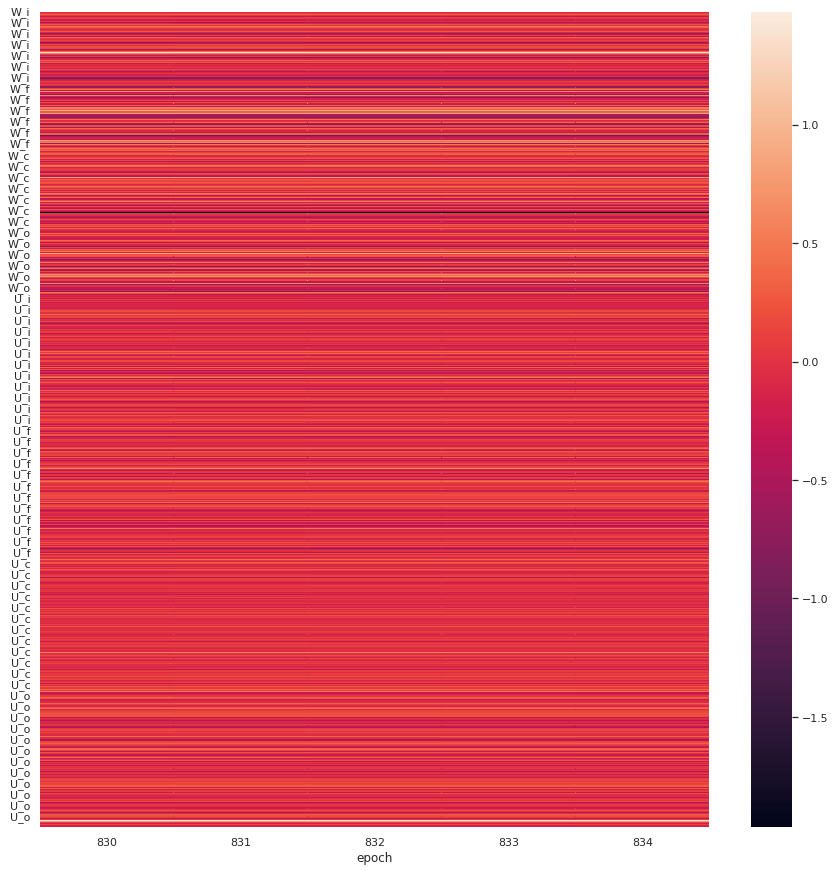

In [459]:
def get_LSTM_UWb(weight):

    warr,uarr, barr = weight
    gates = ["i","f","c","o"]
    hunit = uarr.shape[0]
    U, W, b = {},{},{}
    for i1,i2 in enumerate(range(0,len(barr),hunit)):
        
        W[gates[i1]] = warr[:,i2:i2+hunit]
        U[gates[i1]] = uarr[:,i2:i2+hunit]
        b[gates[i1]] = barr[i2:i2+hunit].reshape(hunit,1)
    return(W,U,b)

def get_LSTMweights(model1):
    for layer in model1.layers:
        if "LSTM" in str(layer):
            w = layer.get_weights()
            W,U,b = get_LSTM_UWb(w)
            break
    return W,U,b
def vectorize_with_labels(W,U,b):
    bs,bs_label,ws,ws_label,us,us_label=[],[],[],[],[],[]
    for k in ["i","f","c","o"]:
        temp = list(W[k].flatten())
        ws_label.extend(["W_"+k]*len(temp))
        ws.extend(temp)

        temp = list(U[k].flatten())
        us_label.extend(["U_"+k]*len(temp))
        us.extend(temp)    

        temp = list(b[k].flatten())
        bs_label.extend(["b_"+k]*len(temp))
        bs.extend(temp)  
    weight = ws + us + bs
    wlabel = ws_label + us_label + bs_label
    return(weight,wlabel)
from copy import copy
df = {}
for epoch in np.arange(830,835):
    
    model1=load_model('LSTM/'+'weights.'+str(epoch)+'.hdf5')
    weight=model1.layers[1].get_weights()
    WUb = get_LSTMweights(model1)
    weight,wlabel = vectorize_with_labels(*WUb)
    df["{:03d}".format(epoch)] = copy(weight)
import pandas as pd
df = pd.DataFrame(df,index=wlabel)
df = df[np.sort(df.columns)]

plt.figure(figsize=(15,15))
sns.heatmap(df)
plt.xlabel('epoch')
plt.show()

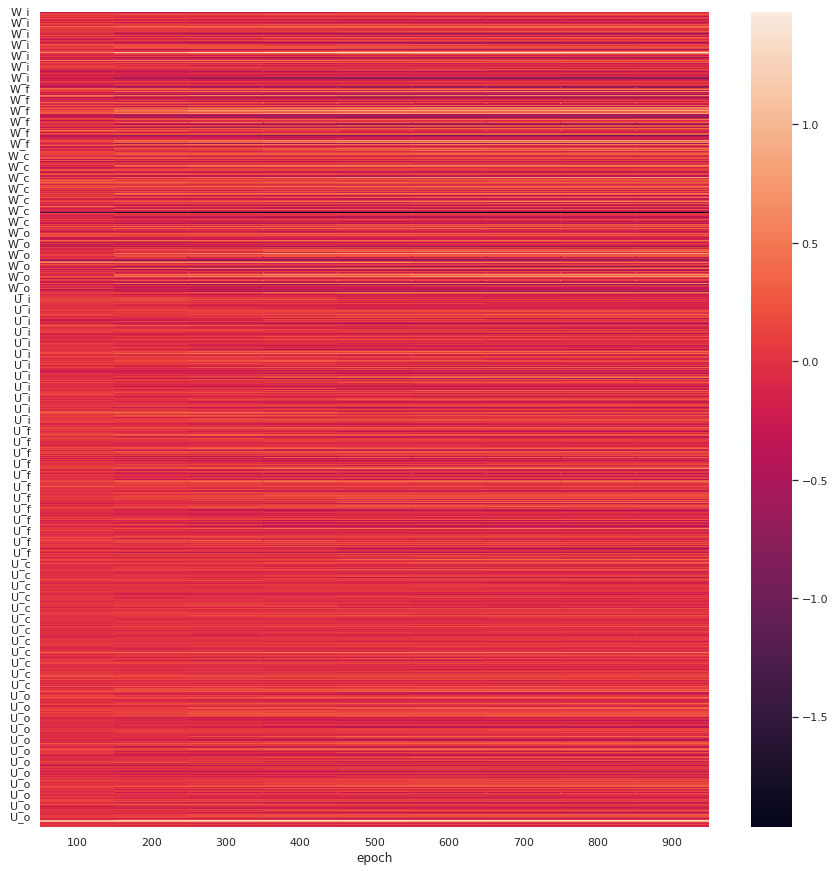

In [457]:
import pandas as pd
df = pd.DataFrame(df,index=wlabel)
df = df[np.sort(df.columns)]

plt.figure(figsize=(15,15))
sns.heatmap(df)
plt.xlabel('epoch')
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
np.savetxt('inone/vloss.txt',val_loss)
np.savetxt('inone/loss.txt',loss)
np.savetxt('inone/vacc.txt',val_acc)
np.savetxt('inone/acc.txt',acc)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.savefig('inone/acc.png')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('inone/vloss.png')
plt.show()

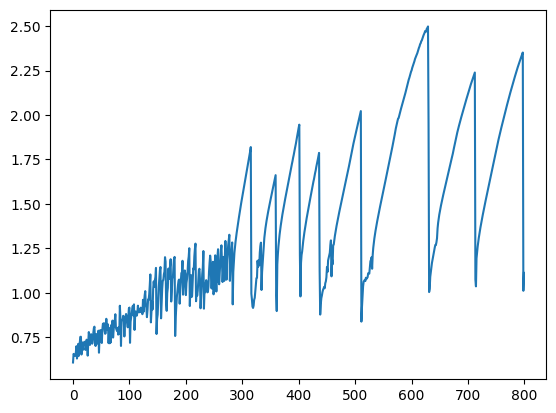

In [50]:
aax=[]
aav=[]
with open('LSTM/vloss.txt', 'r') as f:
            for line in f.readlines():
                aax+=np.float64(line.strip('\n').split(' ')).tolist()
           
plt.plot(aax[200:1000])

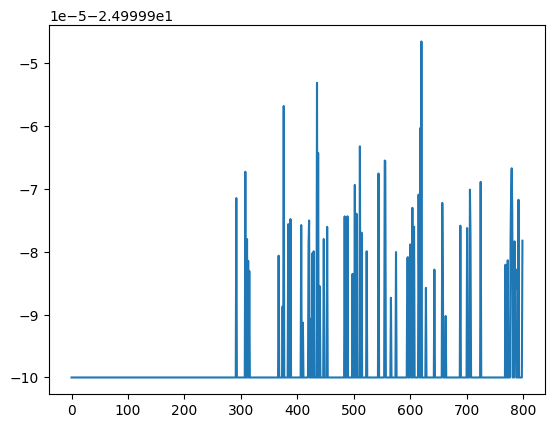

In [51]:
with open('papercon/LSTM.txt', 'r') as f:
            for line in f.readlines():
                aav+=np.float64(line.strip('\n').split(' ')).tolist()
plt.plot(aav)

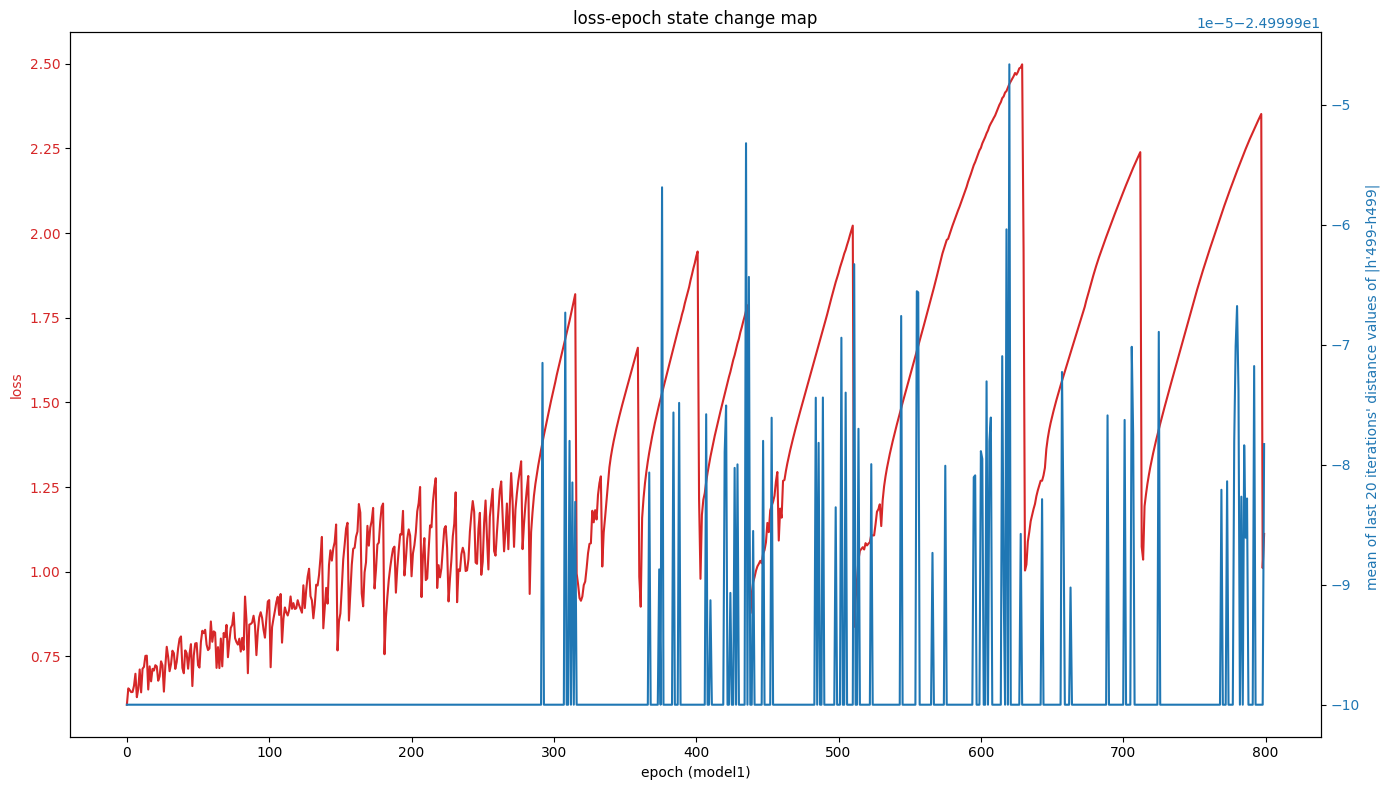

In [52]:
l=[]
with open('paper2/nobiasfloat64distanc.txt') as f:
    for line in f.readlines():
        line=line.strip('\n')
        l.append(float(line))




xl=[]
with open('LSTM/vloss.txt') as f:
    for line in f.readlines():
        line=line.strip('\n')
        xl.append(float(line))
xl1=[]
with open('LSTM/xfloat64distanc.txt') as f:
    for line in f.readlines():
        line=line.strip('\n')
        xl1.append(float(line))        
#plt.scatter(np.arange(991),l)
fig, ax1 = plt.subplots(figsize=(14,8))

#plt.xlim(0,1001)
color = 'tab:red'
ax1.set_xlabel('epoch (model1)')
ax1.set_ylabel('loss', color=color)
ax1.plot(np.arange(len(aax[200:1000])),aax[200:1000], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text('loss-epoch state change map')
ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴

color = 'tab:blue'
ax2.set_ylabel("mean of last 20 iterations' distance values of |h'499-h499| ", color=color)
#ax2.plot(np.arange(1,1001),ll, color=color)
ax2.plot(np.arange(len(aav)),aav, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
#fig.savefig('paper22/loss-epoch state change map.png')
plt.show()

In [7]:
if tf.test.is_gpu_available():
    print("GPU is available and visible to TensorFlow.")
    print("Number of available GPUs: ", tf.config.list_physical_devices('GPU'))
else:
    print("GPU is not available or not visible to TensorFlow.")

GPU is available and visible to TensorFlow.
Number of available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-21 14:58:58.439408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /device:GPU:0 with 31119 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0
